# CSC 2621 Final Project
**Authors:**  Thomas Benzshawel, Lucas Gral, Ben Paulson<Br/>
Section 131

[Associated GitHub Repository](https://github.com/ThomasBenzshawel/dasci-final)

[Associated Presentation Link](https://msoe365-my.sharepoint.com/:p:/g/personal/benzshawelt_msoe_edu/EWkYlq08PrZJo2wi0vCZnZ8B92eyS7vgOyK56dRwD4Ze7g?e=A6op41)

# Introduction
<span style="color:lightblue">**For developers running the cells, skip part 1 and only do the import/constants cells below and skip to part 2 to load the cleaned/processed dataset.**</span>


Lab about determining sentiment of Steam reviews. 

For our original project proposal, we proposed predicting whether a game review on Steam is positive or negative through sentiment analysis. This will be done through a variety of approaches, including supervised and unsupervised learning approaches – as well as the publicly available [Kaggle Dataset](https://www.kaggle.com/datasets/andrewmvd/steam-reviews/code) which contains around 6 million Steam reviews. Steam, as outlined in our [Final Presentation](https://msoe365-my.sharepoint.com/:p:/g/personal/benzshawelt_msoe_edu/EWkYlq08PrZJo2wi0vCZnZ8B92eyS7vgOyK56dRwD4Ze7g?e=A6op41), is a platform for purchasing a playing video games on PC, allowing users to leave reviews for games they’ve played. This fosters a community of games who care about games, resulting in a large dataset of reviews for this project. 
This exploration is important because Steam reviews are a subjective artifact which ultimately affect the performance of a game; when on the fence, users are more likely to purchase a game that is highly rated as opposed to a game that has a low user rating. Therefore, by understanding signals of sentiment for individual terms as well as across genres, we can better comprehend how user perceptions and preferences influence the market dynamics of video games. This understanding could provide valuable insights for developers and marketers in tailoring their products and strategies to better meet the expectations of their target audience. Additionally, the application of machine learning in analyzing these reviews not only aids in quantifying subjective opinions but also contributes to the broader field of natural language processing and sentiment analysis. 


In [2]:
# Other data sources
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# ML/DL
from sklearn.model_selection import train_test_split
import torch
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
import numpy as np

# Common EDA tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway, kruskal

# Default packages
import os
import csv
from collections import defaultdict

# Misc
from tqdm.notebook import tqdm  # Progress bar tool


#idk
from sklearn import preprocessing
from collections import OrderedDict
from sklearn.cluster import KMeans
import umap
# import hdbscan

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paulsonb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulsonb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
ALPHA_VALUE = 0.05

In [3]:
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Part 1: Data Exploration

### Part 1a: Data Importing & Description
The main dataset that will be used throughout this analysis is https://www.kaggle.com/datasets/andrewmvd/steam-reviews/code. This dataset contains 6.4 million reviews from the Steam platform; users are only able to review the game if they have bought and played the game. The reviews are from 2014 to 2017. The dataset contains the following columns: `app_id`, `app_name`, `review_text`, `review_score`, `review_votes`. The definition for each column is as follows:
* **app_id**: Unique ID of the game
* **app_name**: Name of the game
* **review_text**: Text of the review
* **review_score**: Score of the review (1 is positive, -1 is negative)
* **review_votes**: Number of votes the review received for 'helpfulness'

In this dataset, there are 6,417,106 reviews, reviewing 9,363 unique games. The average review score is 0.6395, meaning the average review of these 9,363 games is a positive review. The average review vote score is 0.147, meaning the community does not identify most reviews as being helpful by at least one person. Also, the average number of characters per review is 304, with the smallest being 1 and the largest being 8,873. Also, interestingly, there are over 8,000 reviews which are single-character, with "." being the most popular at 4,885 reviews.

In this dataset, there are 631 games with ratings of 100% based on the reviews given (which is a subset of the total reviews on Steam)

The datatypes of each of the different columns is as follows:
|id|Column|Dtype|
|---|---|---|
 0|app_id|int64 
 1|app_name|object
 2|review_text|object
 3|review_score|int64 
 4|review_votes|int64 

**memory usage:** 244.8+ MB

In [19]:
review_data = pd.read_csv("dataset.csv")
review_data.columns

Index(['app_id', 'app_name', 'review_text', 'review_score', 'review_votes'], dtype='object')

In [20]:
review_data.describe()

,app_id,review_score,review_votes
count,6.417106e+06,6.417106e+06,6.417106e+06
mean,2.274695e+05,6.394992e-01,1.472446e-01
std,1.260451e+05,7.687918e-01,3.543496e-01
min,1.000000e+01,-1.000000e+00,0.000000e+00
25%,2.018100e+05,1.000000e+00,0.000000e+00
50%,2.391600e+05,1.000000e+00,0.000000e+00
75%,3.056200e+05,1.000000e+00,0.000000e+00
max,5.653400e+05,1.000000e+00,1.000000e+00


### Part 1b: Importing Genre Data Using NLP to get the Genre of Each Game
In order to add the "genre" column for this dataset, an LLM was used to process the title of the game and assign a specific genre classification; there are 109 unique genres in this dataset. Because the LLM was trained up to 2021, and the training data was a majority of reputable sources across the internet, an assumption can be made that the model was able to accurately inference the genre from the title due to its knowledge of the title existing on game storefronts like Steam. Verificiation of 10 games resulted in 100% accuracy of the LLM's labeling.

Beyond this data collection, the genre titles were also cleaned manually. Manual cleaning was done to merge similar genre titles (ie "Zombie", "Zombies", "Zombies.", etc...), and to remove blank genre titles for games which could not be processed by the LLM. These games were unable to be processed either due to inappropriate language in the title or inappropriate language for the genre title ("Shoot-em up"). Further, non-manual cleaning can be seen in `Part 2: Cleaning & Preprocessing`

In [10]:
genre_data = pd.read_csv("steam_game_genre_manual_clean.csv")
genre_data.drop(columns=['number_of_reviews', 'Unnamed--0', 'review_score'], inplace=True)
genre_data = genre_data.drop_duplicates(subset=['app_name'])
genre_data.rename(columns={'answer':'genre'}, inplace=True)
genre_data.columns

Index(['app_name', 'genre'], dtype='object')

In [11]:
# Merge with the review_data dataframe to include genre with the games
review_data = review_data.merge(genre_data, on='app_name', how='left')
review_data

,app_id,app_name,review_text,review_score,review_votes,genre
0,10,Counter-Strike,Ruined my life.,1,0,Shooter
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter
2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter
...,...,...,...,...,...,...
6417101,99910,Puzzle Pirates,I really ove this game but it needs somethings...,-1,0,Puzzle
6417102,99910,Puzzle Pirates,"Used to play Puzzel Pirates 'way back when', b...",-1,0,Puzzle
6417103,99910,Puzzle Pirates,"This game was aright, though a bit annoying. W...",-1,0,Puzzle
6417104,99910,Puzzle Pirates,"I had a nice review to recommend this game, bu...",-1,0,Puzzle


### Exploration 1: Average Review Score by Game
**Intro:** Group the dataset by game and calculate the average review score for each game within this dataset. Also get a count for the number of reviews for each game.

**Conclusion:** While an initial hypothesis was made that games with a higher number of reviews would not be present in either of the `review_score=1.0` or `review_score=-1.0` baskets, there are multiple games with over 100 reviews yet have only positive or negative reviews respectively. Also, looking at the visualization below for "Review Score vs Number of Reviews", it appears there is a slight trend for more reviews being given for good games. This makes sense since good games likely reach a larger audience, meaning there is a larger number of players who could potentially write a review for the game.

In [15]:
# Get the average review_score for each unique app_name
df = review_data[['app_name', 'review_score']].groupby('app_name').mean().reset_index().sort_values(by='review_score', ascending=False).reset_index(drop=True)

# Add a column called number_of_reviews to the dataframe
df['number_of_reviews'] = review_data[['app_name', 'review_score']].groupby('app_name').count().reset_index()['review_score']
df

,app_name,review_score,number_of_reviews
0,Discovering Colors - Animals,1.0,14
1,Fabric,1.0,26
2,Trigonarium,1.0,103
3,Aveyond 3-3: The Lost Orb,1.0,27
4,Aveyond 3-4: The Darkthrop Prophecy,1.0,63
...,...,...,...
9358,Angle of Attack,-1.0,2
9359,Retool,-1.0,1
9360,Ke-Tsu-No-Ana,-1.0,5
9361,3D Sprite Renderer and Convex Hull Editor,-1.0,190


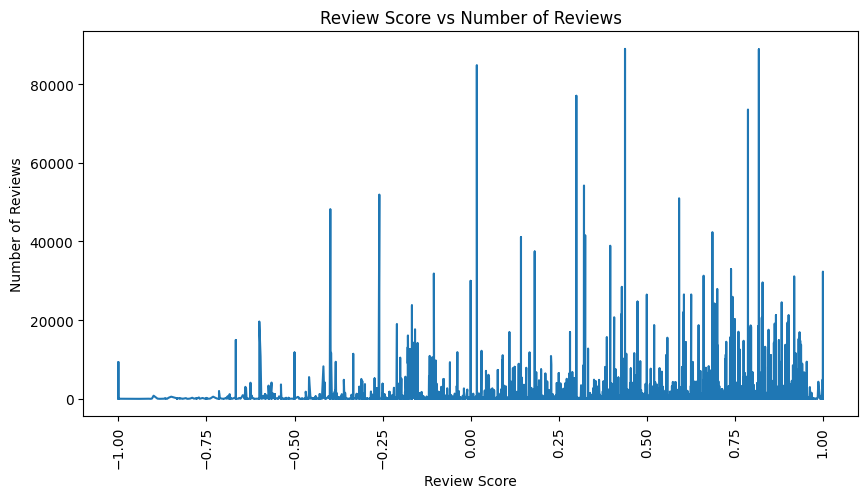

In [25]:
# Plot a bar chart of the review_score for each app_name and the y axis is the number of reviews
plt.figure(figsize=(10, 5))
plt.plot(df['review_score'], df['number_of_reviews'])
plt.xticks(rotation=90)
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.title('Review Score vs Number of Reviews')
plt.show()

### Exploration 2: Early Access Reviews
**Intro:** Early access games are typically buggy and not ready for full release; however, game developers release early access games to get feedback from the community. This is a double-edged sword because people who play Early Access Games are typically avid gamers or are following the development journey intently, meaning they may be less harsh in their review. However, becuase the game is typically glitchy, early access games may experience more negative reviews. This exploration will look at the average review score for early access games vs non-early access games and see if there is a noticeable difference.

**Conclusion:** Early access reviews are 15% of the total reviews in this dataset. The average review score for early access reviews is 58.16% whereas the average review score for non early access reviews is 65.04%. This is a difference of 6.88%. Further analysis will be done in `Part 3: Statistical Analysis` to determine if this difference is statistically significant.

In [40]:
# From the review_data dataframe, filter to only reviews which include "Early Access Review" in the review_text column
early_access_reviews = review_data.dropna(subset=['review_text'])
early_access_reviews = early_access_reviews[early_access_reviews['review_text'].str.contains("Early Access Review")]

# Get reviews which do not include "Early Access Review" in the review_text column
non_early_access_reviews = review_data.dropna(subset=['review_text'])
non_early_access_reviews = non_early_access_reviews[~non_early_access_reviews['review_text'].str.contains("Early Access Review")]

In [41]:
# Calculate the average review score for early_access_reviews. Don't group by app name
print("AVERAGE REVIEW SCORE FOR EARLY ACCESS: ", early_access_reviews[['review_score']].mean()[0])

# Calculate the average review score for review_data
print("AVERAGE REVIEW SCORE FOR ALL REVIEWS: ", non_early_access_reviews[['review_score']].mean()[0])

print("DIFFERENCE IN AVERAGE REVIEW SCORE: ", non_early_access_reviews[['review_score']].mean()[0] - early_access_reviews[['review_score']].mean()[0])

AVERAGE REVIEW SCORE FOR EARLY ACCESS:  0.5815624222375104
AVERAGE REVIEW SCORE FOR ALL REVIEWS:  0.6504070717316064
DIFFERENCE IN AVERAGE REVIEW SCORE:  0.06884464949409597


### Exploration 3: Term Frequency for Positive/Negative Reviews
**Intro:** Determining the term frequency within positive/negative reviews is a common technique for sentiment analysis and some words may be more common in positive reviews than negative reviews and vice versa. This exploration will utilize the reviews dataset where "stop words" were cleaned from the review text. Therefore, the data will be directly pulled from the saved csv of `dataset_with_genre_no-stopwords.csv`. To see how this cleaning was done, please see `Part 2: Cleaning & Preprocessing`.

**Conclusion:** The top 10 most common words in positive reviews are: game, 's, The, n't, like, play, it, fun, good, and get. The top 10 most common words in negative reviews are: game, n't, 's, the, like, get, play, it, even, and time. Since these top 10 words are different, it is likely the exact terms used in the phrasing of the review can be used to determing the sentiment of the review and therefore the positivity/negativity of the review. This will be explored further in `Part 3: Statistical Analysis`.

In [6]:
# The "Cleaned" Dataset; review the text above for more info
review_data = pd.read_csv('dataset_with_genre_no-stopwords.csv')
review_data.drop(columns=['Unnamed: 0'], inplace=True)
review_data

,app_id,app_name,review_text,review_score,review_votes,genre,stopwords_removed
0,10,Counter-Strike,Ruined my life.,1,0,Shooter,Ruined life .
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter,"This `` experience game '' type review , sayin..."
2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter,This game saved virginity .
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter,• Do like original games ? • Do like games n't...
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter,"Easy learn , hard master ."
...,...,...,...,...,...,...,...
6417101,99910,Puzzle Pirates,I really ove this game but it needs somethings...,-1,0,Puzzle,I really ove game needs somethings . It 's bas...
6417102,99910,Puzzle Pirates,"Used to play Puzzel Pirates 'way back when', b...",-1,0,Puzzle,"Used play Puzzel Pirates 'way back ' , Steam ...."
6417103,99910,Puzzle Pirates,"This game was aright, though a bit annoying. W...",-1,0,Puzzle,"This game aright , though bit annoying . When ..."
6417104,99910,Puzzle Pirates,"I had a nice review to recommend this game, bu...",-1,0,Puzzle,"I nice review recommend game , know n't purcha..."


In [5]:
# Divide the reviews by positivity and negativity
positive_reviews = review_data[review_data['review_score'] == 1][['review_score', 'stopwords_removed', 'genre']]
negative_reviews = review_data[review_data['review_score'] == -1][['review_score', 'stopwords_removed', 'genre']]

In [35]:
# Get the count by term for each review, divide by genre
positive_reviews_count = {}
negative_reviews_count = {}

for genre in tqdm(review_data['genre'].unique()): # All genres
    positive_reviews_count[genre] = defaultdict(int)
    negative_reviews_count[genre] = defaultdict(int)

    for review in positive_reviews[positive_reviews['genre'] == genre]['stopwords_removed']:
        review = str(review)
        for word in review.split():
            positive_reviews_count[genre][word] += 1

    for review in negative_reviews[negative_reviews['genre'] == genre]['stopwords_removed']:
        review = str(review)
        for word in review.split():
            negative_reviews_count[genre][word] += 1

100%|██████████| 110/110 [01:29<00:00,  1.23it/s]


In [36]:
# Get the top 10 most common words (more that one character) for positive and negative reviews by genre
top_10_positive_reviews = {}
top_10_negative_reviews = {}

for genre in tqdm(review_data['genre'].unique()):
    # Be sure the word is more than one character
    positive_reviews_count[genre] = {k:v for k,v in positive_reviews_count[genre].items() if len(k) > 1}
    negative_reviews_count[genre] = {k:v for k,v in negative_reviews_count[genre].items() if len(k) > 1}

    # Sort the dictionary by value
    positive_reviews_count[genre] = {k: v for k, v in sorted(positive_reviews_count[genre].items(), key=lambda item: item[1], reverse=True)}
    negative_reviews_count[genre] = {k: v for k, v in sorted(negative_reviews_count[genre].items(), key=lambda item: item[1], reverse=True)}

    # Get the top 10 most common words
    top_10_positive_reviews[genre] = list(positive_reviews_count[genre].keys())[:10]
    top_10_negative_reviews[genre] = list(negative_reviews_count[genre].keys())[:10]

100%|██████████| 110/110 [00:03<00:00, 27.60it/s]


In [37]:
top_10_positive_reviews

{'Shooter': ['game',
  "'s",
  'The',
  'like',
  "n't",
  'fun',
  'play',
  'good',
  'get',
  'It'],
 'Fighting': ['game',
  "'s",
  'Review',
  'Early',
  'Access',
  'The',
  "n't",
  'fighting',
  'like',
  'play'],
 'Action': ['game',
  "'s",
  'The',
  "n't",
  'like',
  'fun',
  'play',
  'good',
  'It',
  'get'],
 nan: [],
 'Adventure': ['game',
  "'s",
  'The',
  "n't",
  'story',
  'like',
  'It',
  'games',
  'one',
  'This'],
 'Sports': ['game',
  'fun',
  "'s",
  'play',
  "n't",
  'like',
  'The',
  'This',
  'It',
  'get'],
 'Card': ['game',
  "'s",
  'play',
  'cards',
  'The',
  "n't",
  'like',
  'card',
  'get',
  'fun'],
 'Mystery': ['game',
  "'s",
  'The',
  "n't",
  'story',
  'like',
  'It',
  'one',
  'games',
  'good'],
 'Simulation': ['game',
  'Review',
  'Early',
  'Access',
  "'s",
  "n't",
  'like',
  'The',
  'It',
  'fun'],
 'Strategy': ['game',
  "'s",
  'The',
  'like',
  "n't",
  'games',
  'play',
  'one',
  'It',
  'good'],
 'Puzzle': ['game',
  

In [38]:
top_10_negative_reviews

{'Shooter': ['game',
  "n't",
  "'s",
  'The',
  'like',
  'play',
  'get',
  'Review',
  'Early',
  'Access'],
 'Fighting': ['game',
  "n't",
  "'s",
  'The',
  'play',
  'like',
  'get',
  'even',
  'Early',
  'Access'],
 'Action': ['game',
  "n't",
  "'s",
  'The',
  'like',
  'get',
  'play',
  'It',
  'even',
  'time'],
 nan: [],
 'Adventure': ['game',
  "n't",
  "'s",
  'The',
  'like',
  'story',
  'It',
  'really',
  'get',
  'one'],
 'Sports': ['game',
  "n't",
  "'s",
  'play',
  'The',
  'like',
  'get',
  'even',
  'It',
  '...'],
 'Card': ['game',
  "n't",
  'cards',
  'play',
  "'s",
  'The',
  'get',
  'like',
  'card',
  'time'],
 'Mystery': ['game',
  "n't",
  "'s",
  'The',
  'like',
  'story',
  'It',
  'get',
  'really',
  'one'],
 'Simulation': ['game',
  "n't",
  "'s",
  'The',
  'like',
  'get',
  'Early',
  'Access',
  'Review',
  'It'],
 'Strategy': ['game',
  "n't",
  "'s",
  'The',
  'like',
  'play',
  'get',
  'It',
  'even',
  'one'],
 'Puzzle': ['game',
 

# Part 2: Cleaning & Preprocessing


### Part 2a: General Data Cleaning

**Removal of "Stop Words"**<br/>
Stop words are general terms which are frequently cleaned from datasets when doing NLP for reduction in noise, focusing on only the most meaningful words without an attention mechanism, and to reduce the size of the dataset.**

In [4]:
################# EXTREMELY LONG-RUNNING CELL (30 MIN); INSTEAD, LOAD FROM FILE BELOW #############################
# stopwords_list = set(stopwords.words('english'))
# def remove_stop_words(text, stopwords):
#     word_tokens = word_tokenize(text)
#     filtered_sentence = [w for w in word_tokens if not w in stopwords]
#     return " ".join(filtered_sentence)

# review_data_no_stopwords = review_data['review_text'].apply(lambda x: remove_stop_words(str(x), stopwords_list))
# review_data['no_stopwords'] = review_data_no_stopwords
# review_data.to_csv('dataset_with_genre_no-stopwords.csv')
###################################################################################################################

review_data = pd.read_csv('dataset_with_genre_no-stopwords.csv')
review_data.drop(columns=['Unnamed: 0'], inplace=True)
review_data['genre'] = review_data['genre'].astype(str) # Make sure event nan values are strings
review_data.head()

,app_id,app_name,review_text,review_score,review_votes,genre,stopwords_removed,normalized_review_score,normalized_review_votes
0,10,Counter-Strike,Ruined my life.,1,0,Shooter,Ruined life .,1.0,0.0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter,"This `` experience game '' type review , sayin...",1.0,1.0
2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter,This game saved virginity .,1.0,0.0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter,• Do like original games ? • Do like games n't...,1.0,0.0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter,"Easy learn , hard master .",1.0,1.0


In [ ]:

# Saved to be used in later processes so the data-cleaning process doesn't have to be run every time
# review_data.to_csv('dataset_with_genre_no-stopwords.csv')

**Normalization/Standardization of Data**<br/>
Normalization/Standardization of data is a crucial step of preprocessing due to the large range of data within our dataset. This can be especially seen in the numerical difference between `review_score` and `review_votes` for reviews which have substantially more votes. Without normalization, the larger scale of `review_votes` would dominate the smaller scale of `review_score`.

In [ ]:
# Showcased in presentation -- constrained between 0 and 1

### Part 2b Specific Cleaning for Supervised Learning Models

Bert tokens will be used for both supervised models, so an instance of a bert tokenizer is being instantiated below.

Furthermore, some other common functionalities between the supervised approaches are below: a lambda applied to the dataframes for ignoring special characters, and a train-test-split function.

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ignore_special = lambda x: x.encode('ascii',errors='ignore').decode()

def supervised_train_test_split(review_data, total_samples=100_000, test_samples=1000):
    '''Select equal number of positive and negative training samples, then take subset of that for testing samples.'''
    positive_df = review_data[review_data['review_score']==1].sample(total_samples//2)
    negative_df = review_data[review_data['review_score']==-1].sample(total_samples//2)

    train_df = pd.concat([positive_df, negative_df]).sample(frac=1)
    test_df = train_df[-test_samples:]
    train_df = train_df[:-test_samples]

    return train_df, test_df

### Part 2b.1: Specific Cleaning for Supervised Learning Models (KNN)

In [6]:
# TODO: write full reasoning.
# For KNN, just keep arrays of stopwords_removed and review_score as binary class.

In [112]:
# train-test split.

knn_train_df, knn_test_df = supervised_train_test_split(review_data[['stopwords_removed', 'review_score']])

assert pd.Series(np.concatenate([knn_test_df.index, knn_train_df.index])).value_counts().max() == 1 # no duplicates

In [113]:
for df in [knn_train_df, knn_test_df]:
    df['stopwords_removed'] = df['stopwords_removed'].astype(str).apply(ignore_special)

In [114]:
# cache mapping from unique terms to bert token ids (will be faster than using bert tokenizer directly)
knn_unique_term_to_ids = {}
# for review in tqdm(knn_train_df['stopwords_removed'].astype(str).apply(str.lower).apply(str.split)):
for review in tqdm(knn_train_df['stopwords_removed'].apply(str.lower).apply(str.split)):
    for term in  review:
        if term not in knn_unique_term_to_ids:
            knn_unique_term_to_ids[term] = bert_tokenizer(term)['input_ids'][1:-1]

100%|██████████| 99000/99000 [00:10<00:00, 9638.37it/s] 


In [115]:
def knn_get_review_tfs(review_str):
    review_tok_ids = []
    for term in review_str.lower().split():
        try: review_tok_ids += knn_unique_term_to_ids[term]
        except KeyError: review_tok_ids += bert_tokenizer(term)['input_ids'][1:-1] # manually tokenize unknown terms (much slower than dict lookup)
    return dict(zip(*np.unique(review_tok_ids, return_counts=True)))

In [116]:
# get tfs of train & test reviews
knn_train_df['review_tfs'] = [knn_get_review_tfs(review) for review in tqdm(knn_train_df['stopwords_removed'].astype(str))]
knn_test_df['review_tfs'] = [knn_get_review_tfs(review) for review in tqdm(knn_test_df['stopwords_removed'].astype(str))]

  3%|▎         | 2913/99000 [00:00<00:03, 29127.04it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8799.42it/s]


In [117]:
knn_test_df.head()

,stopwords_removed,review_score,review_tfs
2381546,"nice playing rhytm , good experiment .",1,"{1010: 1, 1012: 1, 1054: 1, 2204: 1, 2652: 1, ..."
3161136,"This bad game common sense . It starts ok , di...",-1,"{1005: 1, 1010: 4, 1012: 8, 1045: 2, 1055: 1, ..."
1873331,Early Access Review,1,"{2220: 1, 3229: 1, 3319: 1}"
5925120,Early Access Review,1,"{2220: 1, 3229: 1, 3319: 1}"
3748848,I love game ..... finally W40k game gets atmos...,1,"{1005: 8, 1006: 1, 1007: 1, 1010: 11, 1012: 31..."


In [118]:
# store bert token idfs

knn_tok_idfs = {}
# start by storing num of documents containing T for each tok T
for review_tfs in tqdm(knn_train_df['review_tfs']):
    for tok in review_tfs.keys():
        knn_tok_idfs[tok] = knn_tok_idfs.get(tok, 0) + 1
# Apply log(N / df)
N = len(knn_train_df)
for k, v in tqdm(knn_tok_idfs.items()):
    knn_tok_idfs[k] = np.log(N / v)

100%|██████████| 22236/22236 [00:00<00:00, 874131.10it/s]


In [119]:
def knn_get_tok_idf(tok):
    try: return knn_tok_idfs[tok]
    except KeyError: return 20 # some high number, since the term not having occured means it's rare

def knn_get_review_tf_idfs(review, tfs_supplied=False):
    review_tfs = review if tfs_supplied else knn_get_review_tfs(review)
    return {t: f*knn_get_tok_idf(t) for t, f in review_tfs.items()}

In [120]:
# calculate tf-idf of train & test reviews

knn_train_df['review_tf_idfs'] = [knn_get_review_tf_idfs(review_tfs, tfs_supplied=True) for review_tfs in tqdm(knn_train_df['review_tfs'])]
knn_test_df['review_tf_idfs'] = [knn_get_review_tf_idfs(review_tfs, tfs_supplied=True) for review_tfs in tqdm(knn_test_df['review_tfs'])]

100%|██████████| 1000/1000 [00:00<00:00, 14030.87it/s]


In [121]:
# Lastly, normalize review scores into categories 1 (positive), 0 (negative)
knn_train_df['review_score'] = (1+knn_train_df['review_score'])//2
knn_test_df['review_score'] = (1+knn_test_df['review_score'])//2

In [122]:
# CACHE THE NORMS
knn_train_df['norms'] = [np.linalg.norm(list(tf_idfs.values())) for tf_idfs in tqdm(knn_train_df['review_tf_idfs'])]
knn_test_df['norms'] = [np.linalg.norm(list(tf_idfs.values())) for tf_idfs in tqdm(knn_test_df['review_tf_idfs'])]

100%|██████████| 1000/1000 [00:00<00:00, 115427.91it/s]


In [123]:
# remove the very few exceptions where there were no valid terms in the original review

knn_train_df = knn_train_df[knn_train_df['norms'] != 0]
knn_test_df = knn_test_df[knn_test_df['norms'] != 0]

In [124]:
knn_train_df.reset_index(inplace=True, drop=True)
knn_test_df.reset_index(inplace=True, drop=True)

In [190]:
knn_train_df['review_tf_idfs'][0]

{1012: 3.048627924663978,
 2051: 2.0670738928711745,
 2063: 3.3778360317489815,
 2102: 4.771713828743834,
 2123: 6.865813960113771,
 2131: 1.880822536271913,
 5949: 3.7757806443368853,
 27263: 7.495541943884256}

In [126]:
# Final data going into KNN

knn_train_df

,stopwords_removed,review_score,review_tfs,review_tf_idfs,norms
0,dont waste time pice ....... Dont get,0,"{1012: 7, 2051: 1, 2063: 1, 2102: 2, 2123: 2, ...","{1012: 3.048627924663978, 2051: 2.067073892871...",12.994711
1,Not really good . Horrible Controls .,0,"{1012: 2, 2025: 1, 2204: 1, 2428: 1, 7711: 1, ...","{1012: 0.8710365499039937, 2025: 2.99654068103...",7.017112
2,Way better Fifty Shades Grey,1,"{2126: 1, 2488: 1, 4462: 1, 5595: 1, 13178: 1}","{2126: 2.6579621782171783, 2488: 2.68839612910...",14.230163
3,Early Access Review,0,"{2220: 1, 3229: 1, 3319: 1}","{2220: 1.7135646216429983, 3229: 1.73509275874...",2.918625
4,I ca n't recommend game full price . Fun first...,0,"{1002: 3, 1005: 3, 1006: 1, 1007: 1, 1010: 5, ...","{1002: 10.469589056243434, 1005: 2.86015324748...",45.996247
...,...,...,...,...,...
98878,This amazing story-based adventure . I started...,1,"{1011: 1, 1012: 5, 1045: 2, 1996: 1, 2023: 1, ...","{1011: 1.7402025732228275, 1012: 2.17759137475...",25.477771
98879,Early Access Review,0,"{2220: 1, 3229: 1, 3319: 1}","{2220: 1.7135646216429983, 3229: 1.73509275874...",2.918625
98880,It 's Walking Dead game much fun,1,"{1005: 1, 1055: 1, 2009: 1, 2172: 1, 2208: 1, ...","{1005: 0.9533844158294709, 1055: 1.54324356596...",7.536597
98881,How win game : Step 1 : Spam sabotage Step 2 :...,1,"{1012: 1, 1015: 1, 1016: 1, 1017: 1, 1024: 4, ...","{1012: 0.43551827495199685, 1015: 3.0144930195...",25.392554


### Part 2b.2: Specific Cleaning for Supervised Learning Models (BERT fintuning)

In [7]:
bert_train_df, bert_test_df = supervised_train_test_split(review_data[['stopwords_removed', 'review_score']], test_samples=500)

In [8]:
bert_train_x = [x[:1500] for x in bert_train_df['stopwords_removed'].astype(str).apply(ignore_special)]
bert_test_x = [x[:1500] for x in bert_test_df['stopwords_removed'].astype(str).apply(ignore_special)]

bert_train_y = torch.tensor((bert_train_df['review_score'].values+1)//2)
bert_test_y = torch.tensor((bert_test_df['review_score'].values+1)//2)

### Part 2c: Specific Cleaning for Clustering

In [ ]:
# Division for x and y in preparation for genre-classification training
train_test_split(review_data, test_size=0.2, random_state=42)

# Part 3: Statistical Analysis
We will utilize an alpha-value ($\alpha$) of 0.05 for all statistical tests.

In this section, we will be performinig different statistical analysis on the dataset to determine if there are any statistically significant relationships between different variables or groups of the dataset. This includes an analysis of the following:
* Relationship between `genre` and `review_score`
* Relationship between `review_score` and `review_length`
* Relationship between `review_length` and `review_votes`
* Statistical significance of the difference between the average review score of early access games vs non-early access games

Another relationship that should be recognized with this dataset is that the population we're pulling from does not meet the condition for creating a normally-distributed sample means graph. This is because of the following reasons:
* **Central Limit Theorem (CLT):** This condition can still be met. With the large number of reviews, a sample size of 30 is acceptable for creating a distribution of average review scores
* **Independence of Observations:** The CLT assumes that samples are also independent of each other. Since we see that the distribution is not normal, this condition may not be met. This could be because of the ["bandwagoning" effect](https://www.verywellmind.com/what-is-the-bandwagon-effect-2795895#:~:text=The%20bandwagon%20effect%20refers%20to%20the%20tendency%20of,other%20people%20will%20also%20hop%20on%20the%20bandwagon.) with game reviews.
* **Identical Distribution:** Samples must be drawn from the same distribution, meaning the scoring criteria for the game cannot change over time. This is condition is NOT met because games receive regular updates, so reviews may be more negative/positive during a certain timeframe based on the recency of a bad/good update.

For a graphic showcasing the distribution of average review scores, see the graphic below. This graphic show a bell-curve distribution, but it is not a normal distribution, as verified by `scipy.stats.normaltest` in another code cell below.

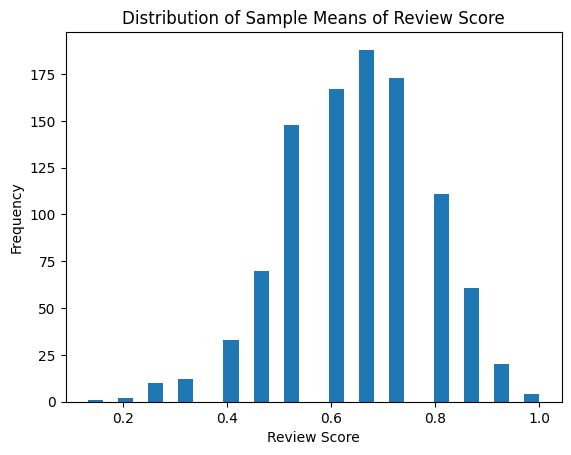

In [72]:
# NOTE: This cell takes a long time to run (~10 minutes)
# Create a distribution of sample means of review_score where the sample size is 30 reviews
sample_means = []

for i in range(1000):
    sample = review_data.sample(n=30)
    sample_means.append(sample['review_score'].mean())

plt.hist(sample_means, bins=30)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sample Means of Review Score')
plt.show()

In [77]:
# Quantitatively measuring how "normal" the data is
from scipy.stats import normaltest

statistic, p = normaltest(sample_means)

# Interpret p
if p > ALPHA_VALUE:
    print('The distribution is Normal (fail to reject H0)')
else:
    print('The distribution is NOT Normal (reject H0)')

The distribution is not Normal (reject H0)


### Part 3a: Chi-Squared Test for Independence Between All Features and Review Score
Using a similar approach as seen during lab 4, we will be performing a chi-squared test for independence between all features and `review_score`. This will be done to determine if there is a statistically significant relationship between each feature and review score. Features which are not categorical will be removed from the testing.
* **Null Hypothesis:** There is no relationship between the feature and review score
* **Alternative Hypothesis:** There is a relationship between the feature and review score

**Conclusion:** For each variable, the p-value is less than 0.05 (`ALPHA_VALUE`), meaning we can reject the null hypothesis for each feature. This means there is a statistically significant relationship between each feature and the value of review score.

In [50]:
def determine_combination_counts(var_name, df, filter_var="review_score"):
    """
    Determine the combination counts for a certain variable name in df
    :param str var_name: Feature to extract
    :param pd.DataFrame df: Dataframe to extract from
    :return: Combination counts
    """
    return pd.crosstab(df[var_name], df[filter_var])

In [55]:
chi_test_results = {}
FILTER_VAR = "review_score"
for i, var_name in enumerate(review_data.columns):
    if var_name == FILTER_VAR: # Output variable
        continue

    if var_name == 'app_id' or var_name == 'review_text' or var_name == 'stopwords_removed' or var_name == 'review_votes': # Non-categorical data
        continue

    chi_test_results[var_name] = chi2_contingency(determine_combination_counts(var_name, review_data, filter_var = FILTER_VAR))

In [56]:
# Compile stat-test results into a dataframe (variable name, pvalue, whether or not the correlation is statistically significant)
results_table = pd.DataFrame(columns=['Variable Name', 'p-value', 'Statistically Significant?'])
for var_name in chi_test_results.keys():
    significant = chi_test_results[var_name][1] < ALPHA_VALUE
    results_table = pd.concat([results_table, pd.DataFrame({'Variable Name': var_name, 'p-value': [chi_test_results[var_name].pvalue], 'Statistically Significant?': significant})], ignore_index=True)

# Order by statistical significance
results_table = results_table.sort_values(by=['Statistically Significant?'], ascending=False)
results_table

,Variable Name,p-value,Statistically Significant?
0,app_name,0.0,True
1,genre,0.0,True


In [68]:
unique_genres = review_data['genre'].unique()
scores_by_genre = review_data[['genre', 'review_score']].groupby('genre').mean()['review_score']

array(['Shooter', 'Fighting', 'Action', nan, 'Adventure', 'Sports',
       'Card', 'Mystery', 'Simulation', 'Strategy', 'Puzzle', 'MOBA',
       'Platformer', 'RPG', 'Arcade', 'Sci-fi', 'Boardgame', 'Survival',
       'Racing', 'Thriller', 'Fantasy', 'Stealth', 'Roguelike', 'MMORPG',
       'Space', 'Pinball', 'Horror', 'Fashion', 'FPS', 'Animation',
       'Rhythm', 'Benchmark', "Shoot'em-up", 'Documentary', 'Music',
       'Visual novel', 'Visual Novel', 'Tower Defense', 'Chess', 'Comedy',
       'Development', 'Exploration', 'Photography', 'Recording', 'Zombie',
       'Utility', 'Art', 'Retro', 'Electronic', 'Educational', 'Drama',
       'Building', 'Role-playing', 'Trivia', 'Casual', 'Design', 'Casino',
       'Indie', 'Cyberpunk', 'Romance', 'Capture', 'Western',
       'Miscellaneous', 'Streaming', 'Hidden Object', 'Narrative',
       'Driving', 'Superhero', 'Steampunk', 'Dating', 'Tactical', 'Heist',
       'Family', 'Word game', 'Video', 'Metroidvania', 'Party', 'Metal',
    

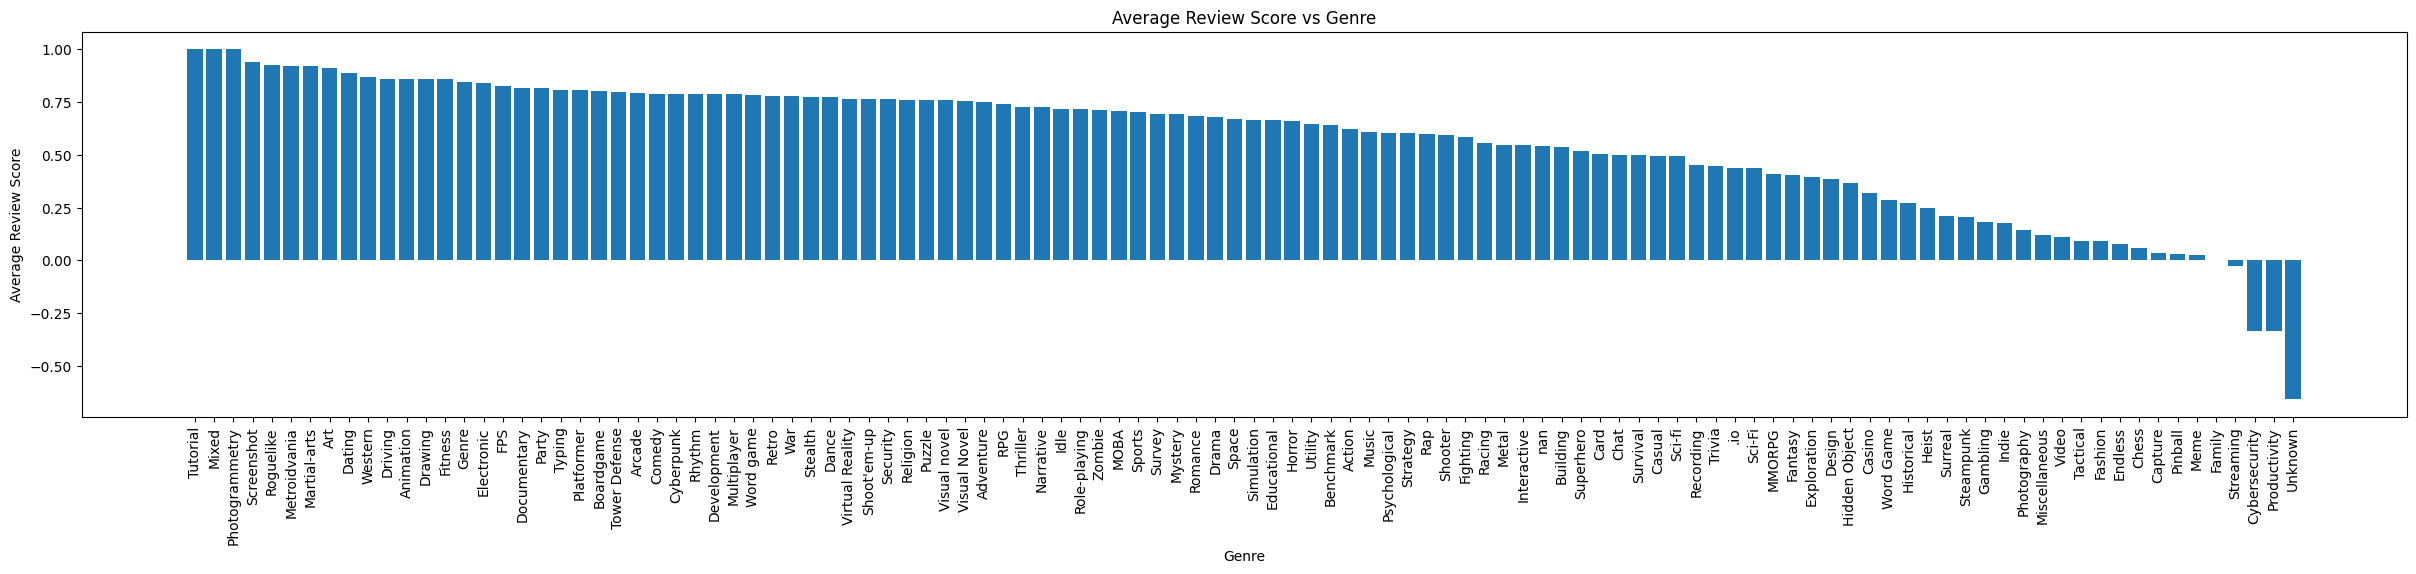

In [74]:
mean_scores = review_data.groupby('genre')['review_score'].mean()
mean_scores = mean_scores.sort_values(ascending=False)

plt.figure(figsize=(30, 5))
plt.bar(mean_scores.index, mean_scores.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Average Review Score')
plt.title('Average Review Score vs Genre')
plt.show()


## Part 3b: Kruskal Wallis for Review Score vs Number of Votes
The Kruskal-Wallis test is a non-parametric test which is used to determine if there is a statistically significant difference between the medians of two or more groups. This test is used when the data does not meet the assumptions of a parametric test (ie normal distribution, equal variance, etc...). In this case, we will be using the Kruskal Wallis test to determine if there is a statistically significant difference between the median review score for reviews with a low number of votes vs reviews with a high number of votes.
* **Null Hypothesis:** There is no relationship between the number of votes for a review and the review score<br/>
* **Alternative Hypothesis:** There is a relationship between the number of votes for a review and the review score

**Conclusion:** _________________________

In [8]:
def determine_samples_by_group(var_name, df, filter_var="review_score"):
    """
    Determine the samples by group for a certain variable name in df
    :param str var_name: Feature to extract
    :param pd.DataFrame df: Dataframe to extract from
    :return: Samples by group
    """
    samples_by_group = [] 
    for value in set(df[var_name]): 
        mask = df[var_name] == value 
        samples_by_group.append(df[filter_var][mask])

    return samples_by_group

# Run stat tests
kruskal_wallis_results = {}
for var_name in review_data.columns:
    if not var_name == 'review_votes':
        continue
    samples_by_group = determine_samples_by_group(var_name, review_data)
    kruskal_wallis_results[var_name] = kruskal(*samples_by_group)

# Compile stat-test results into a dataframe (variable name, pvalue, whether or not the correlation is statistically significant)
results_table = pd.DataFrame(columns=['Variable Name', 'p-value', 'Statistically Significant?'])
for var_name in kruskal_wallis_results.keys():
    significant = kruskal_wallis_results[var_name].pvalue < ALPHA_VALUE
    results_table = pd.concat([results_table, pd.DataFrame({'Variable Name': var_name, 'p-value': [kruskal_wallis_results[var_name].pvalue], 'Statistically Significant?': significant})], ignore_index=True)

# Order by statistical significance
results_table = results_table.sort_values(by=['Statistically Significant?'], ascending=False)
results_table

,Variable Name,p-value,Statistically Significant?
0,review_votes,0.0,True


### Part 3c: Kruskal Wallis Test for Review Score vs Review Length
The Kruskal-Wallis test is a non-parametric test which is used to determine if there is a statistically significant difference between the medians of two or more groups. This test is used when the data does not meet the assumptions of a parametric test (ie normal distribution, equal variance, etc...). In this case, we will be using the Kruskal Wallis test to determine if there is a statistically significant difference between the median review score for reviews with a low review length vs reviews with a high review length.
* **Null Hypothesis:** There is no relationship between the review length and the review score<br/>
* **Alternative Hypothesis:** There is a relationship between the review length and the review score

**Conclusion:** _________________________

In [5]:
# Create an additional column for review length
review_data['review_length'] = review_data['review_text'].str.len()
review_data

,app_id,app_name,review_text,review_score,review_votes,genre,stopwords_removed,normalized_review_score,normalized_review_votes,review_length
0,10,Counter-Strike,Ruined my life.,1,0,Shooter,Ruined life .,1.0,0.0,15.0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter,"This `` experience game '' type review , sayin...",1.0,1.0,2357.0
2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter,This game saved virginity .,1.0,0.0,29.0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter,• Do like original games ? • Do like games n't...,1.0,0.0,220.0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter,"Easy learn , hard master .",1.0,1.0,48.0
...,...,...,...,...,...,...,...,...,...,...
6417101,99910,Puzzle Pirates,I really ove this game but it needs somethings...,-1,0,Puzzle,I really ove game needs somethings . It 's bas...,0.0,0.0,537.0
6417102,99910,Puzzle Pirates,"Used to play Puzzel Pirates 'way back when', b...",-1,0,Puzzle,"Used play Puzzel Pirates 'way back ' , Steam ....",0.0,0.0,543.0
6417103,99910,Puzzle Pirates,"This game was aright, though a bit annoying. W...",-1,0,Puzzle,"This game aright , though bit annoying . When ...",0.0,0.0,281.0
6417104,99910,Puzzle Pirates,"I had a nice review to recommend this game, bu...",-1,0,Puzzle,"I nice review recommend game , know n't purcha...",0.0,0.0,379.0


In [14]:
# Run Kruskal Wallis test on review length
samples_by_group = determine_samples_by_group('genre', review_data)
kruskal_wallis_results = kruskal(*samples_by_group)

In [17]:
kruskal_wallis_results.pvalue

0.0

In [23]:
results_table = pd.DataFrame(columns=['Variable Name', 'p-value', 'Statistically Significant?'])
significant = kruskal_wallis_results.pvalue < ALPHA_VALUE
results_table = pd.concat([results_table, pd.DataFrame({'Variable Name': 'review_length', 'p-value': [kruskal_wallis_results.pvalue], 'Statistically Significant?': significant})], ignore_index=True)
results_table

,Variable Name,p-value,Statistically Significant?
0,review_length,0.0,True


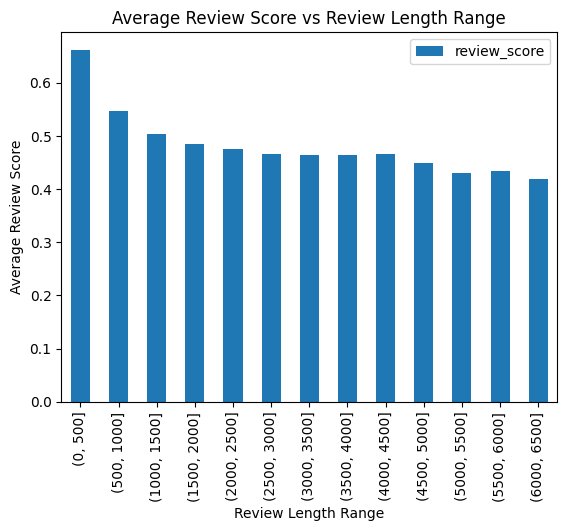

In [35]:
# Create bar chart showing the average review score versus ranges of different review lengths. Make the graph big
review_data['review_length_range'] = pd.cut(review_data['review_length'], bins=list(range(0, 7000, 500)))
review_data[['review_length_range', 'review_score']].groupby('review_length_range').mean().plot.bar()
plt.xlabel('Review Length Range')
plt.ylabel('Average Review Score')
plt.title('Average Review Score vs Review Length Range')
plt.show()


### Part 3d: Statistical Significance of Early Access Reviews
In `Exploration 2` of `Part 1: Data Exploration`, it was found that the average review score for early access reviews is 58.16% whereas the average review score for non early access reviews is 65.04%. This is a difference of 6.88%.
* **Null Hypothesis:** There is no significant difference between the average review score of early access games and non-early access games.
* **Alternative Hypothesis:** There is a significant difference between the average review score of early access games and non-early access games.

**Conclusion:** Since the distribution of review scores is not normal (the values are binary -1, 1), a statistical test not requiring normality must be used. Based on those covered in class, the best statistic test appears to be the Chi-Squared Test of independence. For these statistical tests, we continue to use an alpha-value ($\alpha$) of 0.05. Based on this tests, the p-value is 0.0, meaning we can reject the null hypothesis and accept the alternative hypothesis. This means there is a significant difference between the average review score of early access games and non-early access games.

In [58]:
early_access_counts = early_access_reviews['review_score'].value_counts().sort_index()
non_early_access_counts = non_early_access_reviews['review_score'].value_counts().sort_index()

In [60]:
# Create the contingency table as a DataFrame.
index = [-1, 1]  # The possible values for the review scores.
early_access_counts = early_access_counts.reindex(index, fill_value=0)
non_early_access_counts = non_early_access_counts.reindex(index, fill_value=0)

# Create the contingency table as a DataFrame.
contingency_table = pd.DataFrame({
    'Early Access': early_access_counts,
    'Non-Early Access': non_early_access_counts
})
contingency_table

,Early Access,Non-Early Access
review_score,,
-1,214398,941287
1,810357,4443759


In [63]:
# Perform the chi-squared test of independence.
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results.
print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected, "\n")

# Interpret the p-value
if p_value < ALPHA_VALUE:
    print("The difference in review scores between early access and non-early access is statistically significant.")
else:
    print("There is no statistically significant difference in review scores between early access and non-early access.")

Chi-squared Statistic: 6902.089980733008
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[ 184762.98752099  970922.01247901]
 [ 839992.01247901 4414123.98752099]] 

The difference in review scores between early access and non-early access is statistically significant.


# Part 4: Sentiment Analysis Experiments (Supervised Models)

### Part 4a: KKN w/ tfidf
Using the labels (positivity/negativity)
[TODO more and clean text]

In [127]:
knn_vec_and_norm_lookup = np.array(list(zip(knn_train_df['review_tf_idfs'], knn_train_df['norms'])))
knn_dists = np.zeros(len(knn_train_df))

def knn_get_nearest(input_str_or_tfidfs, K=20, tfs_supplied=False, input_norm=None):
    global knn_dists, knn_vec_and_norm_lookup
    knn_dists[:] = 0

    v1 = knn_get_review_tf_idfs(input_str_or_tfidfs, tfs_supplied=tfs_supplied)
    norm1 = np.linalg.norm(list(v1.values())) if input_norm == None else input_norm

    for i in (range(len(knn_train_df))):
        v2, norm2 = knn_vec_and_norm_lookup[i]
        dp=0
        for k, v in v1.items():
            if k in v2: dp += v2[k]*v
        dp /= norm2
        knn_dists[i] = dp

    knn_dists = 1 - knn_dists/norm1

    return np.argsort(knn_dists)[:K]

def knn_classify(nearest_ids):
    return int(knn_train_df['review_score'][nearest_ids].values.mean().round())

def knn_print_nearest(input_str):
    nearest_ids = knn_get_nearest(input_str, K=10)[:10]
    for score, rev in list(zip(
        knn_train_df['review_score'][nearest_ids].values,
        knn_train_df['stopwords_removed'][nearest_ids].values
    )):
        print(f'({"positive" if score else "negative"}): {rev}')

In [130]:
knn_print_nearest('would play again')

(positive): Again .... would n't buy ?
(positive): 10/10 Would Rate Again .
(negative): 0/10 WOULD NOT N WORD AGAIN
(positive): 10/10 Would Idle Again .
(positive): 10/10 Would Make Meth Again
(positive): I 've lost control life . Again .
(positive): 11/10 would kill again/win friend killed I
(positive): I mostly play video games violent content game . 10/10 Would Kill Again
(positive): This game inexplicably addictive , I adore . Through hardest annoying achievements easiest Godly Runs , game keep coming back . And And . And Again AnD AgAin @ nD aGaIn .... 10/10 need Moar
(positive): Easy concept grasp ( escape hexagon closes ) , VERY VERY VERY difficult master . Soundtrack amazing , get past constantly dying hearing 'AGAIN ' 'AGAIN ' 'AGAIN ' , , . It 's fun game , long muster patience saint ... 7/10


**Results**

[TODO: some text]

In [157]:
ks = [10, 50, 100, 150, 500, 1000, 1500, 2000, 5000, 10000]

In [147]:
nearest_to_test_samples = []
review_scores = []

for tf_idfs, norm, review_score in tqdm(zip(knn_test_df['review_tf_idfs'], knn_test_df['norms'], knn_test_df['review_score']), total=len(knn_test_df)):
    nearest_ids = knn_get_nearest(tf_idfs, input_norm=norm, tfs_supplied=True, K=ks[-1])
    nearest_to_test_samples.append(nearest_ids)
    review_scores.append(review_score)

100%|██████████| 998/998 [06:40<00:00,  2.49it/s]


In [158]:
knn_test_results = {k:[] for k in ks} # {k: [(pred, actual), ...], ...}

for k in tqdm(ks):
    for nearest_ids, review_score in zip(nearest_to_test_samples, review_scores):
        pred = knn_classify(nearest_ids[:k])
        knn_test_results[k].append((pred, review_score))
    knn_test_results[k] = np.array(knn_test_results[k])

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


In [159]:
accuracies = []
precisions = []
recalls = []

for k in ks:
    results = knn_test_results[k]
    preds = results[:,0]
    actuals = results[:,1]
    corrects = preds == actuals

    accuracies.append(corrects.sum() / len(knn_test_df))
    precisions.append((corrects * (actuals == 1)).sum()/(preds==1).sum())
    recalls.append((corrects * (actuals == 1)).sum()/(actuals==1).sum())

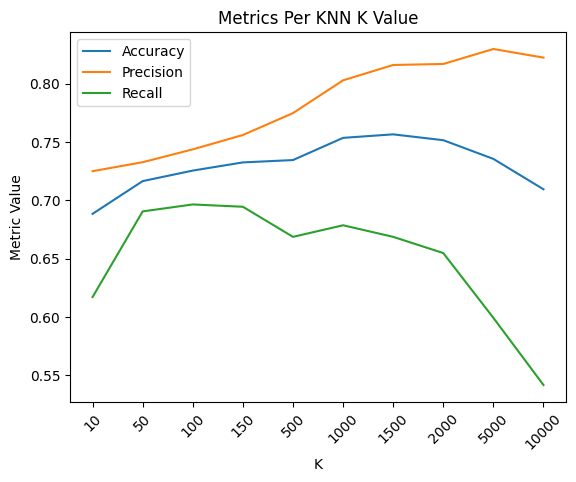

In [165]:
plt.title('Metrics Per KNN K Value')
plt.ylabel('Metric Value')
plt.xlabel('K')
plt.xticks(ticks=np.arange(0,len(ks)), labels=ks, rotation=45)
plt.plot(accuracies, label='Accuracy')
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.legend()
plt.show()

In [179]:
best_precision_idx = np.argmax(precisions)
best_recall_idx = np.argmax(recalls)

In [186]:
print(
    'Best Precision:',
    '\nk =', ks[best_precision_idx],
    '\nPrecision:', precisions[best_precision_idx]
)

print(
    '\nBest Recall:',
    '\nk =', ks[best_recall_idx],
    '\nRecall:', recalls[best_recall_idx]
)

Best Precision: 
k = 5000 
Precision: 0.8296703296703297

Best Recall: 
k = 100 
Recall: 0.6964285714285714


In [176]:
best_accuracy_idx = np.argmax(accuracies)

print(f'''
    Metrics of Best KNN Model (by Accuracy)
    Accuracy: {accuracies[best_accuracy_idx]:.3f}
    Precision: {precisions[best_accuracy_idx]:.3f}
    Recall: {recalls[best_accuracy_idx]:.3f}
    K: {ks[best_accuracy_idx]}
''')


    Metrics of Best KNN Model (by Accuracy)
    Accuracy: 0.757
    Precision: 0.816
    Recall: 0.669
    K: 1500



### Part 4b: Fine-Tuning BERT
Using the labels (positivity/negativity), a BERT model will be fine-tuned.

A base bert model will have a classification layer added via a pretrained HuggingFace `BertForSequanceClassification` model.
Because we have so much data, the model will be trained and tested on on the previously cleaned subset (`bert_train_x`, `bert_train_y`, `bert_test_x`, `bert_test_y`) for one epoch. 10 samples of test and train loss will be recorded during this training process.

In [9]:
class TunedBert(torch.nn.Module):
    def __init__(self):
        super(TunedBert, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    def forward(self, tokens):
        outputs = self.bert(tokens['input_ids'], attention_mask=tokens['attention_mask'])
        return outputs.logits

In [10]:
model = TunedBert().to(torch_device)

# Just train classification layer
for param in model.bert.bert.parameters():
    param.requires_grad = False

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.4.attention.self.value.bias', 'encoder.layer.9.attention.self.query.weight', 'encoder.layer.7.intermediate.dense.weight', 'encoder.layer.1.attention.output.dense.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.3.output.LayerNorm.bias', 'encoder.layer.2.attention.self.value.weight', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.6.output.dense.weight', 'encoder.layer.7.attention.self.value.bias', 'encoder.layer.2.attention.self.query.bias', 'encoder.layer.3.output.dense.bias', 'encoder.layer.8.intermediate.dense.weight', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.4.attention.output.LayerNorm.weight', 'encoder.layer.5.output.dense.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.8.attention.output.LayerNorm.weight', 

In [13]:
# helps in keeping GPU memory down during development

import gc
temp = gc.collect()
torch.cuda.empty_cache()
temp

385

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss().to(torch_device)

losses = {
    'train' : [],
    'test' : [],
    'accuracy': [] # TEST accuracy
}

test_reviews = bert_tokenizer(
    bert_test_x,
    return_tensors='pt',
    padding=True,
    truncation=True
).to(torch_device)
test_labels = bert_test_y.to(torch_device)

# Fine-tune the model
batch_size = 64
batches_between_testing = (len(bert_train_x) // batch_size)//20 # 20 total metric datapoints
iteration = 0
for i in (pbar := tqdm(range(0, len(bert_train_x), batch_size))):
    # Prepare data
    train_reviews = bert_tokenizer(
        bert_train_x[i : i+batch_size],
        return_tensors='pt',
        padding=True,
        truncation=True
    )
    del train_reviews['token_type_ids']
    train_reviews = train_reviews.to(torch_device)
    train_labels = bert_train_y[i : i+batch_size].to(torch_device)

    # Finetune
    model.train()
    optimizer.zero_grad()
    logits = model(train_reviews)
    loss = criterion(logits, train_labels)
    loss.backward()
    optimizer.step()

    # Testing
    if iteration % batches_between_testing == 0:
        model.eval()
        with torch.no_grad():
            test_loss = 0
            accuracy = 0
            for j in range(0, len(bert_test_x), batch_size):
                pbar.set_description(f'Testing... {j}/{len(bert_test_x)}')
                test_logits = model(test_reviews[j:j+batch_size])
                accuracy += float((test_logits.argmax(axis=1) == test_labels[j:j+batch_size]).sum()) 
                test_loss += float(criterion(test_logits, test_labels[j:j+batch_size]))
            test_loss /= len(bert_test_x) // batch_size
            accuracy /= len(bert_test_x)
        losses['train'].append(float(loss))
        losses['test'].append(float(test_loss))
        losses['accuracy'].append(float(accuracy))

    pbar.set_description(f'Train loss: {loss}. Test loss (latest): {test_loss}. Accuracy (latest) {accuracy}')
    iteration += 1

Train loss: 0.6912323236465454. Test loss (latest): 0.7845496450151715. Accuracy (latest) 0.542: 100%|██████████| 1555/1555 [35:38<00:00,  1.38s/it] 


**Results**

[TODO: discuss & show]

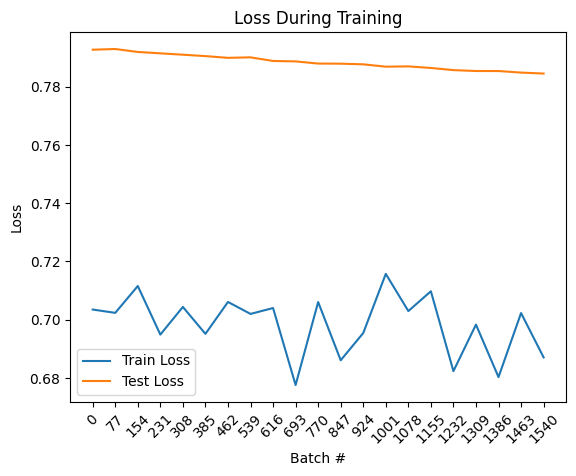

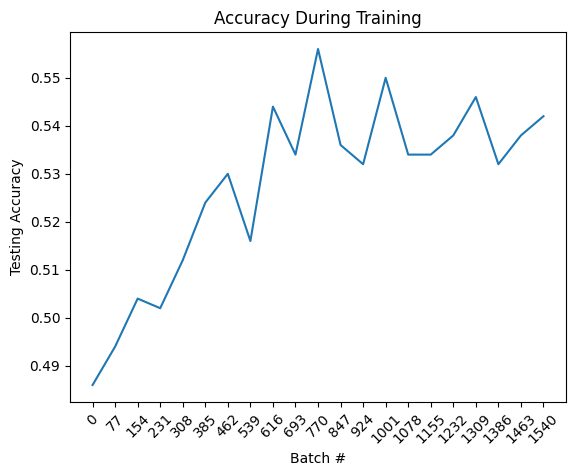

In [24]:
xs = np.arange(0,21)

plt.title('Loss During Training')
plt.plot(losses['train'], label='Train Loss')
plt.plot(losses['test'], label='Test Loss')
plt.ylabel('Loss')
plt.xlabel('Batch #')
plt.xticks(ticks=xs, labels=xs*batches_between_testing, rotation=45)
plt.legend()
plt.show()

plt.title('Accuracy During Training')
plt.plot(losses['accuracy'])
plt.ylabel('Testing Accuracy')
plt.xticks(ticks=xs, labels=xs*batches_between_testing, rotation=45)
plt.xlabel('Batch #')
plt.show()

In [72]:
tp, fp, tn, fn = 0, 0, 0, 0

for i in tqdm(range(0, len(bert_test_x), batch_size)):
    reviews = bert_tokenizer(
        bert_test_x[i : i+batch_size],
        return_tensors='pt',
        padding=True,
        truncation=True
    ).to(torch_device)

    pred = model(reviews).argmax(axis=1)
    labels = bert_test_y[i : i+batch_size].to(torch_device)
    
    tp += float((pred * labels).sum())
    fp += float((pred * (1-labels)).sum())
    tn += float(((1-pred) * (1-labels)).sum())
    fn += float(((1-pred) * labels).sum())

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


In [105]:
print('Accuracy:', (tp+tn)/(tp+tn+fp+fn))
print('Precision:', f'{(tp)/(tp+fp):.3f}')
print('Recall:', f'{(tp)/(tp+fn):.3f}')

Accuracy: 0.564
Precision: 0.584
Recall: 0.516


In [74]:
confusion_matrix = [
    [tp, fp],
    [fn, tn]
]

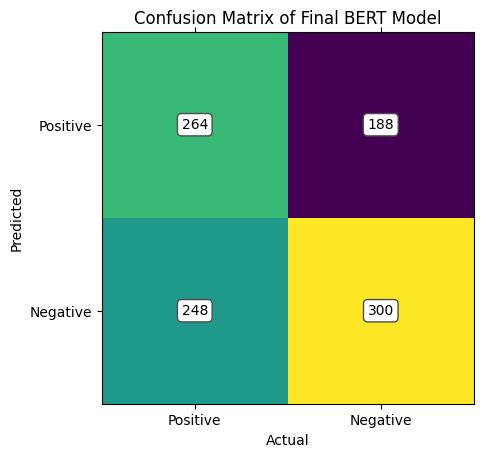

In [107]:
plt.matshow(confusion_matrix)
plt.title('Confusion Matrix of Final BERT Model')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xticks([0,1], labels=['Positive','Negative'])
plt.yticks([0,1], labels=['Positive','Negative'])
plt.tick_params(axis='x', labelbottom=True, labeltop=False)
for (i, j), z in np.ndenumerate(confusion_matrix):
    plt.text(j, i, int(z), ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

# Part 5: Sentiment Analysis Experiments (Clustering)

**Why Use Clustering:** We plan to use clustering to find patterns in the data that we personally cannot see. Something like sub-genres based on context in reviews, and possible correlations between genres and review scores.



**Why Use K-Means Clustering:** At first, we attempted to use a Bert model again to create context vectors on different reviews, however, we ran into a major issue of the vectors coming out as word embeddings, not sentence embeddings. We then tried to cluster the word embeddings but ended up with meaningless information. Thus, we swapped to using the universal sentence encoder (USE).

With USE, we were able to encode complete sentences and cluster based on the sentence vectors. However, we could not use K-means like we originally planned, so we instead used HDBSCAN. HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is used to cluster our data in a much more meaningful way than simple K-means.

**Justify the #Clusters:**  We found these hyperparameters through using the hyperopt package which includes baeysian search. Using baeysian search, we found the hyperparameters that minimized our loss function (see below.)
   
    * Probably make a plot of the average silhouette score across the different cluster sizes

### Part 5a: train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(review_data[['review_text']], review_data[["review_score"]], test_size=0.20, random_state=0)

#### Defining BERT

In [5]:
bert_model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    tokenized_text = tokenized_text[0:512]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    
    # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    
    return tokenized_text, tokens_tensor, segments_tensor

In [7]:
def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation is disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)    # intialized list to store embeddings
    token_vecs_sum = []    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence    
    # loop over tokens in sentence
    for token in token_embeddings:    # "token" is a [12 x 768] tensor    
        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
        
    return token_vecs_sum

In [8]:
def bert_pipeline(data_to_embed, save_embeddings=False):
    context_embeddings = []
    context_tokens = []
    
    for sentence in tqdm(data_to_embed['review_text']):
        tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, bert_tokenizer)
        list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, bert_model)  # make ordered dictionary to keep track of the position of each word
        tokens = OrderedDict()  # loop over tokens in sensitive sentence
        
        for token in tokenized_text[1:-1]:
            # keep track of position of word and whether it occurs multiple times
            if token in tokens:
                tokens[token] += 1
            else:
                tokens[token] = 1  # compute the position of the current token
            token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
            current_index = token_indices[tokens[token]-1]  # get the corresponding embedding
            token_vec = list_token_embeddings[current_index]
    
            # save values
            context_tokens.append(token)
            context_embeddings.append(token_vec)
            
    if save_embeddings:
        filepath = os.path.join('')
        name = 'metadata_small.tsv'
        
        with open(os.path.join(filepath, name), 'w+') as file_metadata:
            for i, token in enumerate(context_tokens):
                file_metadata.write(token + '\n')
                name = 'embeddings_small.tsv'
        
                with open(os.path.join(filepath, name), 'w+') as tsvfile:
                    writer = csv.writer(tsvfile, delimiter='\t')
                    for embedding in context_embeddings:
                        writer.writerow(embedding.numpy())
            
    return context_embeddings

In [27]:
X_train_embed = bert_pipeline(X_train.head(10), save_embeddings=False)
X_test_embed = bert_pipeline(X_test.head(10), save_embeddings=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Visualizing the embedding in TensorBoard
https://projector.tensorflow.org/

### Part 5b: K-Means Clustering

In [ ]:
from nltk.cluster import KMeansClusterer

In [82]:
X_train_norm = preprocessing.normalize([i.numpy() for i in X_train_embed])
X_test_norm = preprocessing.normalize([i.numpy() for i in X_test_embed])

In [83]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans.fit(X_train_norm)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=3, n_init='auto', random_state=0)

In [84]:
from sklearn.metrics import silhouette_score
silhouette_score([i.numpy() for i in X_train_embed], kmeans.labels_, metric='euclidean')

0.03306901

In [89]:
K = range(2, 15)
fits = []
score = []


for k in K:
    # train the model for current value of k on training data
    kmeans = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X_train_norm)

    # append the model to fits
    fits.append(kmeans)

    # Append the silhouette score to scores
    score.append(silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean'))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

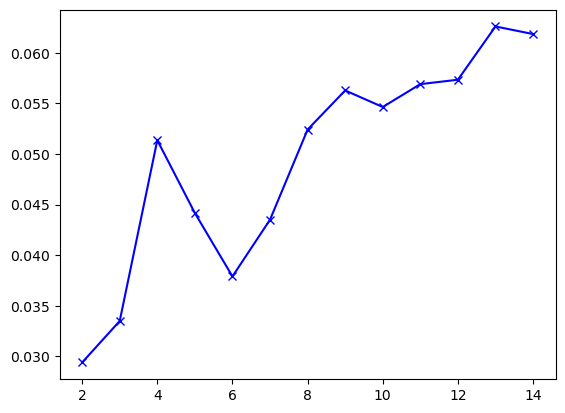

In [90]:
plt.plot(K, score, 'bx-')

This seems off, I think we need to try a different clustering algorithm

# Part 5c: Genre Clustering using HDBSCAN
Source: https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e

In [4]:
def generate_clusters(message_embeddings, n_neighbors, n_components, min_cluster_size, random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """

    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors,
                                 n_components=n_components,
                                 metric='cosine',
                                 random_state=random_state).fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [5]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """

    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)

    return label_count, cost

# Part 5d: Optimizing the number of clusters using Hyperopt and bayesian optimization

In [6]:
X_train, X_test, y_train, y_test = train_test_split(review_data[['review_text']], review_data[["genre", 'review_score']], test_size=0.20, random_state=0)

In [12]:
X_train_embed = bert_pipeline(X_train.head(10), save_embeddings=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
from hyperopt import partial, fmin, tpe, STATUS_OK, Trials, space_eval, hp
import spacy
nlp = spacy.load('en_core_web_sm')
import collections

In [8]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize, which incorporates constraints
    on the number of clusters we want to identify
    """

    clusters = generate_clusters(embeddings,
                                 n_neighbors = params['n_neighbors'],
                                 n_components = params['n_components'],
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])

    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)

    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15
    else:
        penalty = 0

    loss = cost + penalty

    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [9]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """

    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper)
    best = fmin(fmin_objective,
                space = space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")

    best_clusters = generate_clusters(embeddings,
                                      n_neighbors = best_params['n_neighbors'],
                                      n_components = best_params['n_components'],
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])

    return best_params, best_clusters, trials

In [10]:
hspace = {'n_neighbors': 10 + hp.randint('n_neighbors', 10),
         'n_components': 2 + hp.randint('n_components', 10),
         'min_cluster_size': 10 + hp.randint('min_cluster_size', 20),
         'random_state': None}

label_lower = 100
label_upper = 200

In [24]:
best_params, best_clusters, trials = bayesian_search([i.numpy() for i in X_train_embed], space=hspace, label_lower=label_lower, label_upper=label_upper, max_evals=100)

100%|██████████| 100/100 [03:24<00:00,  2.04s/trial, best loss: 0.15]
best:
{'min_cluster_size': 12, 'n_components': 7, 'n_neighbors': 12, 'random_state': None}
label count: 2


# Part 5e: Evaluating the results of the clustering

In [25]:
results_df = generate_clusters([i.numpy() for i in X_train_embed],
                               n_neighbors = best_params['n_neighbors'],
                               n_components = best_params['n_components'],
                               min_cluster_size = best_params['min_cluster_size'])

In [26]:
results_df.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,

As we can see, this is clustering on the word embeddings, not the reviews themselves. We need to find a way to cluster on the reviews themselves.

# Part 5f: Generating new vectors for clustering using the universal sentence encoder

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

In [12]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

In [13]:
def embed(model, inputs):
    return model(inputs)

In [14]:
X_train['review_text'] = X_train['review_text'].astype(str)

In [15]:
to_embed = X_train.head(100_000)['review_text']

In [16]:
embeddings_sentences = embed(model_use, list(to_embed))

In [17]:
hspace = {'n_neighbors': hp.choice('n_neighbors', range(3,64)),
         'n_components': hp.choice('n_components', range(3,64)),
         'min_cluster_size': hp.choice('min_cluster_size', range(2,64)),
         'random_state': None}

label_lower = 100
label_upper = 200

In [18]:
best_params_sent, best_clusters_sent, trials_sent = bayesian_search(
    embeddings_sentences, space=hspace, label_lower=label_lower, label_upper=label_upper, max_evals=100)

 45%|████▌     | 45/100 [1:46:28<1:50:24, 120.45s/trial, best loss: 0.49253]

C:\Users\benzshawelt\AppData\Roaming\Python\Python311\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(



 49%|████▉     | 49/100 [1:53:37<1:33:46, 110.33s/trial, best loss: 0.46766]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited at iteration 8 with accuracies 
[2.17430293e-15 1.19184976e-06 7.10636901e-07 2.28493843e-06
 5.70912580e-06 2.75274769e-06 6.24404082e-06 4.24849693e-06
 4.46944008e-06 4.98802126e-06 5.42888876e-06 1.31330982e-05
 1.36052870e-05 3.08333115e-05 2.68109139e-07 1.24782534e-12
 1.42559118e-13 1.54340922e-13 1.76026152e-13 2.38801147e-13
 9.20143658e-14 5.24677097e-07 2.10033207e-06]
not reaching the requested tolerance 1.640617847442627e-05.
Use iteration 8 instead with accuracy 
4.282304498674024e-06.

  _, diffusion_map = lobpcg(

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[2.39379568e-15 1.19184976e-06 7.10636901e-07 2.28493843e-06
 5.70912580e-06 2.75274769e-06 6.24404082e-06 4.24849693e-06
 4.46944008e-06 4.98802126e-06 5.42888876e-06 1.31330982e-05
 1.36052870e-05 3.08333115e-05 2

 87%|████████▋ | 87/100 [3:25:08<27:44, 128.07s/trial, best loss: 0.46766]  

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Failed at iteration 1 with accuracies [3.03667722e-15 1.63312170e-05 6.71460599e-06 1.07385926e-05
 1.12264819e-05 2.71821022e-05 4.14748478e-06 1.66122911e-05
 4.15561070e-05 2.64138735e-05 8.97331489e-06 2.06278469e-05
 2.02629486e-05 3.20970692e-05 1.77299324e-13 3.55916507e-14
 3.51974807e-14 2.61510699e-14 1.70368748e-14 1.48952079e-14
 1.59047672e-14 1.49008927e-14 1.57031954e-14 1.46791855e-14
 1.57936771e-14 1.48412468e-14 1.54178497e-14 1.49140623e-14
 1.37423081e-14 1.51682844e-14 1.58694510e-14 1.46988795e-14
 1.69670470e-14 1.47527902e-14 1.54728082e-14 1.44084840e-14
 1.46093770e-14 1.39642295e-14 1.39303477e-14 1.52382668e-14
 1.66446393e-14 1.42257095e-14 1.50786511e-14 1.47292080e-14
 1.47648292e-14 1.59513164e-14 1.54836022e-14 1.43048467e-14
 1.42774233e-14 1.49382449e-14 1.57673856e-14 1.53131172e-14
 1.57555161e-14 1.49482760e-14 1.37057993e-14 1.56787261e-14
 1.5859

100%|██████████| 100/100 [4:00:59<00:00, 144.59s/trial, best loss: 0.46766]
best:
{'min_cluster_size': 61, 'n_components': 56, 'n_neighbors': 11, 'random_state': None}
label count: 114


In [19]:
result_clustering = generate_clusters(embeddings_sentences,
                               n_neighbors = best_params_sent['n_neighbors'],
                               n_components = best_params_sent['n_components'],
                               min_cluster_size = best_params_sent['min_cluster_size'])

In [20]:
results_df = pd.DataFrame(to_embed)
results_df['predictions'] = result_clustering.labels_
results_df['score'] = y_train['review_score']
results_df['genre'] = y_train['genre']

In [32]:
results_df.head(20)

,review_text,predictions,score,genre
3538885,This is a fun and interesting game but if your...,-1,1,Action
77010,Its a great game where you can spend thousands...,-1,1,Adventure
5374384,This is the type of game you play at 4 am when...,91,1,Racing
3251914,Early Access Review,2,1,nan
3766018,This and Firearms were two excellent mods for ...,-1,-1,Shooter
5917209,this is an ok game its free and anyone can pla...,-1,1,Shooter
6359419,i cant play the game anymore something like Op...,-1,1,Shooter
6125379,Cute little strategy/puzzle game hybrid. Not t...,15,1,RPG
6263832,One of the best first person shooters I've eve...,100,1,Action
1703012,"Fun Game, Hard at First. This game is extreme...",-1,1,Simulation


# Part 5g: Generating labels for the clusters

In [22]:
def extract_labels(category_docs):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, ojects, and nouns
    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []

    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())

                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())

                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())

                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())

    # take most common words of each form
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]

    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]

    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]

    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]

    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]

    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)

    if '' in label_words:
        label_words.remove('')

    label = '_'.join(label_words)

    return label

In [23]:
def get_group(df, category_col, category):
    """
    Returns documents of a single category
    
    Arguments:
        df: pandas dataframe of documents
        category_col: str, column name corresponding to categories or clusters
        category: int, cluster number to return
    Returns:
        single_category: pandas dataframe with documents from a single category
    """

    single_category = df[df[category_col]==category].reset_index(drop=True)

    return single_category

In [24]:
def most_common(lst, n_words):
    """
    Get most common words in a list of words
    
    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return
    
    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter=collections.Counter(lst)
    return counter.most_common(n_words)

In [25]:
def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """

    numerical_labels = df[category_col].unique()

    # create dictionary of the numerical category to the generated label
    label_dict = {}
    for label in numerical_labels:
        current_category = list(get_group(df, category_col, label)['review_text'])
        label_dict[label] = extract_labels(current_category)

    # create summary dataframe of numerical labels and counts
    summary_df = (df.groupby(category_col)['review_text'].count()
                  .reset_index()
                  .rename(columns={'review_text':'count'})
                  .sort_values('count', ascending=False))

    # apply generated labels
    summary_df['predictions'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)

    return summary_df

In [26]:
cluster_summary = apply_and_summarize_labels(results_df[['review_text', 'predictions']], 'predictions')
cluster_summary.head(20)

,predictions,count
0,game_game_time,50928
3,review_access_game,15688
60,10/10_game_time,2512
90,fun_fun_time,1439
33,game_game_horror,1218
79,run_game_setting,989
73,game_game_player,864
91,game_game_zombie,862
105,game_game_time,851
92,game_friend,844


# Part 6: Evaluation

### Part 6a: Evaluating Supervised Models

In [ ]:
LUCAS GRAL

### Part 6b: Evaluating Clustering Models

In [27]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [28]:
def evaluate_DBSCAN(ground_labels, predicted_labels):
    ari = np.round(adjusted_rand_score(ground_labels, predicted_labels), 3)
    nmi = np.round(normalized_mutual_info_score(ground_labels, predicted_labels), 3)
    
    return ari, nmi

In [29]:
eval_ari, eval_nmi = evaluate_DBSCAN(results_df["genre"], results_df["predictions"])
print("ARI:",eval_ari, "NMI:", eval_nmi)

ARI: 0.024 NMI: 0.156


In [30]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

C:\Users\benzshawelt\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


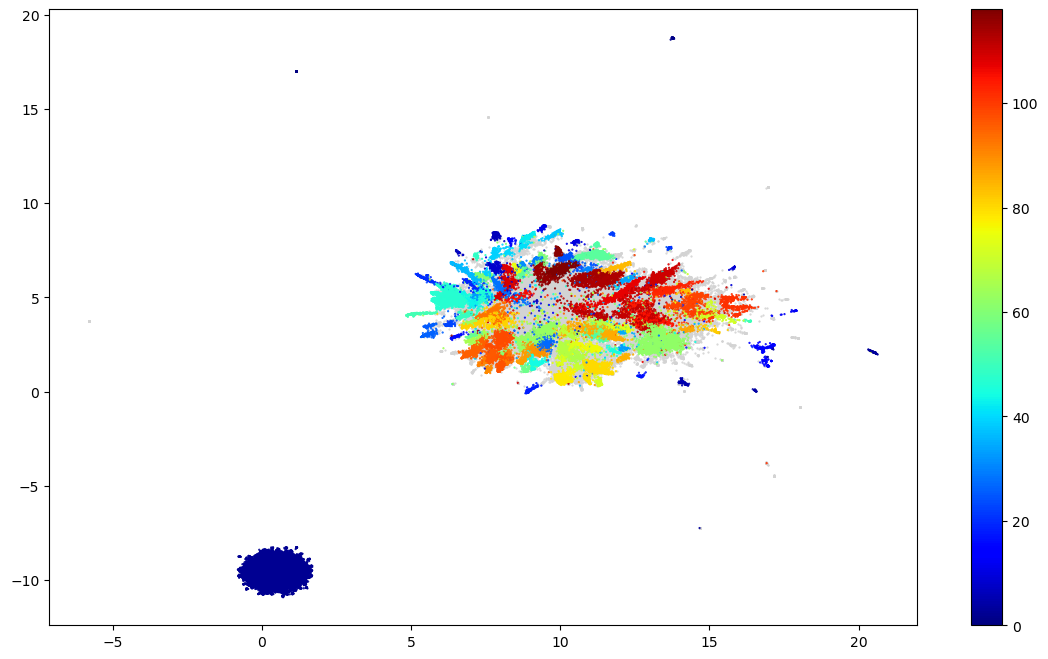

In [31]:
plot_clusters(embeddings_sentences, best_clusters_sent)

# Conclusion
This project has successfully demonstrated the application of various machine learning techniques in the analysis of Steam reviews. Our journey began with the ambitious goal of predicting the sentiment of Steam reviews, a critical aspect that influences gamers' purchasing decisions. Through meticulous data exploration, cleaning, and preprocessing, we were able to prepare a robust dataset for analysis.
Our supervised learning models, including KNN and BERT, provided insightful results into the sentiments of the reviews. The application of these models not only affirmed our hypothesis but also shed light on the nuances of game reviews. The unsupervised learning approaches, especially the use of HDBSCAN, offered a fresh perspective on clustering reviews, revealing patterns that were not immediately apparent.
The statistical analysis section further enriched our understanding by uncovering significant relationships between various features of the dataset and review scores. This analysis was crucial in comprehensively understanding the factors that influence a game's reception on Steam.
An unexpected yet valuable discovery was the similarity among clusters across different genres and review scores. This finding suggests that despite the diverse nature of games and opinions, there are underlying commonalities in how users express their sentiments in reviews.
Our project not only contributes to the understanding of Steam reviews but also advances the field of sentiment analysis in gaming. It highlights the potential of machine learning in transforming how we interpret and analyze user-generated content in digital platforms.


# Contribution Statement
* **Lucas Gral:** Mainly worked on the supervised models, experimenting with different models and different ways of preprocessing the supervised models that were ultimately tried. Also expeirmented with fine-tuning on ROSIE and attempting to get state-of-the-art results compared to those seen on the Kaggle submissions for the associated dataset. Worked on data-cleaning for supervised models specifically; after the data was cleaned generally after the appropriate statistical tests. Also worked on the presentation and the associated slides for these respective sections.

* **Thomas Benzshawel:** Mainly worked on the clustering models, experimenting with different models and different ways of preprocessing the clustering models that were ultimately tried. Worked on data-cleaning for unsupervised models specifically; after the data was cleaned generally after the appropriate statistical tests. Also worked on the presentation and the associated slides for these respective sections, as well as spending a lot of time ensuring his approaches were well-visualized. 

* **Ben Paulson:** Mainly worked on the data exploration and statistical analysis, experimenting with different ways of preprocessing the data and different statistical tests that were ultimately tried for the best graphics showcasing the relationships of data and choosing appropriate data features to ultimately run models with. Also worked on the presentation and the associated slides for these respective sections, as well as defining the background info.

All members worked extensively on the report, each writing about the sections they were responsible for.